# CM3070 Computer Science Final Project
# 02 Emotion Classifier

---

## **Table of Contents**  
1. [Introduction](#introduction)  
2. [Objectives](#objectives)  
3. [Setup and dependencies](#setup-and-dependencies)  
   - [Installing dependencies](#installing-dependencies)  
   - [Setting up file paths](#setting-up-file-paths)    
4. [Loading and preprocessing audio tracks](#loading-and-preprocessing-audio)  
   - [Loading the NPY files](#loading-npy)
   - [Normalising features](#normalising-features)
   - [Defining the test-train split](#defining-the-test-train-split)
5. [Creating a baseline CNN Model](#creating-a-baseline-cnn-model)
   - [Defining the model](#defining-the-model)
   - [Building and training the model](#building-and-training-a-baseline-model)
   - [Evaluating the baseline model](#evaluating-the-baseline-model)
6. [Creating a refined CNN Model](#creating-a-refined-cnn-model)
   - [Introducing hyperparameter tuning](#introducing-hyperparameter-tuning)
   - [Implementing k-fold cross validation](#implementing-k-fold-cross-validation)
   - [Building and training the refined model](#building-and-training-the-refined-model)
   - [Evaluating the refined model](#evaluating-the-refined-model)
7. [Summary and next steps](#summary)

---

## 1. Introduction <a id="introduction"></a>

This notebook marks the second stage of a larger project on **Neural Style Transfer (NST) in Speech**, where the emotional tone of one voice is transferred to another. To evaluate the success of this transformation, we need a reliable model that can classify emotions in speech based on audio features alone.

Here, we focus on building an ** emotion classifier** that can recognize emotions such as *neutral*, *happy*, and *sad* from speech recordings. Using the **CREMA-D** and **RAVDESS** datasets — professionally recorded corpura of emotional speech — we train a convolutional neural network (CNN) to learn from **mel-spectrogram** inputs. This model will later be used to verify whether stylised speech outputs have adopted the intended emotional tone.

---

## 2. Objectives <a id="objectives"></a>

- Load preprocessed mel-spectrogram `.npy` files representing different emotions from the CREMA-D and RAVDESS datasets
- Split the data into training and test sets for supervised learning
- Design and implement a CNN-based model architecture for classifying emotional speech
- Use hyperparameter tuning to choose the best parameters to produce a model of high accuracy
- Train the model using k-fold cross validation for maximum use of the available data
- Monitor its performance using classification reports and confusion matrices
- Save the trained classifier for downstream use in evaluating style transfer results

This classifier will play a key role in the project’s evaluation strategy by providing a quantitative method to assess the emotional accuracy of stylised outputs generated via neural style transfer.

---

## 3. Setup and dependencies <a id="setup-and-dependencies"></a>
### Installing dependencies <a id="installing-dependencies"></a>
In this cell, we install the necessary Python packages for:

- the core deep learning library used to build and train neural network models (`tensorflow`)
- the utility functions such as train-test splitting and evaluation metrics (`scikit-learn`)
- tuning hyperparameters of Keras models (`keras-tuner`)  
- statistical data visualization (`seaborn`)  
- creating and customizing plots (`matplotlib`)

In [1]:
!pip install tensorflow scikit-learn keras-tuner seaborn matplotlib --quiet

### Setting up file paths <a id="setting-up-file-paths"></a>
We will define the path to the .npy files created in the last notebook:

In [2]:
import os

# define base paths
NPYS_DIR = "npys/"

---

## 4. Loading and preprocessing audio tracks <a id="loading-and-preprocessing-audio"></a>
### Loading the NPY files <a id="loading-npy"></a>
We load the pre-extracted mel-spectrograms for the selected emotions and create corresponding numerical labels, returning arrays `X` (features) and `y` (labels) ready for model training.

In [3]:
import numpy as np
import tensorflow as tf

# list of 6 emotions
selected_emotions = ['neutral', 'happy', 'sad', 'angry', 'fearful', 'disgust']
emotion_labels = {label: i for i, label in enumerate(selected_emotions)}

def load_data(npy_dir=NPYS_DIR):
    X, y = [], []
    for emotion in os.listdir(npy_dir):
        if emotion not in selected_emotions:
            continue
        emotion_dir = os.path.join(npy_dir, emotion)
        if not os.path.isdir(emotion_dir):
            continue
        for file in os.listdir(emotion_dir):
            if file.endswith(".npy"):
                filepath = os.path.join(emotion_dir, file)
                features = np.load(filepath, allow_pickle=True).item()
                mel = features["mel"]
                X.append(mel)
                y.append(emotion)
    X = np.stack(X, axis=0).astype("float32")
    y = np.array([emotion_labels[label] for label in y])
    return X, y

X, y = load_data(NPYS_DIR)
print("Loaded:", X.shape, y.shape)

Loaded: (1122, 80, 256) (1122,)


### Normalising features <a id="normalising-features"></a>
We standardize the feature array `X` to have zero mean and unit variance, and set `num_classes` to the number of selected emotions for classification.

In [4]:
X = (X - np.mean(X)) / np.std(X)

num_classes = len(selected_emotions)

### Defining the test-train split <a id="defining-the-test-train-split"></a>
We split the dataset into training and testing sets (80/20) while preserving class proportions.

In [5]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train = X_train[..., np.newaxis]
X_test  = X_test[..., np.newaxis]

y_train = to_categorical(y_train, num_classes=num_classes)
y_test  = to_categorical(y_test, num_classes=num_classes)

---

## 5. Creating a baseline CNN Model <a id="creating-a-baseline-cnn-model"></a>
### Defining the model <a id="defining-the-model"></a>
We define a convolutional neural network (CNN) for emotion classification:

- The model consists of multiple convolutional layers with ReLU activation and max-pooling.  
- A flattening layer converts feature maps to a 1D vector.  
- A dense hidden layer with dropout is added to reduce overfitting.  
- The output layer uses softmax activation to predict probabilities for each emotion class.  
- The model is compiled with the Adam optimizer, categorical crossentropy loss, and accuracy as the evaluation metric.

In [6]:
from tensorflow.keras import layers, models

def build_cnn_model(
    input_shape=(80, 256, 1),
    num_classes=num_classes,
    filters=[32, 64, 128],
    dense_units=128,
    dropout_rate=0.3,
    learning_rate=1e-3
):
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))

    for f in filters:
        model.add(layers.Conv2D(f, (3,3), activation="relu", padding="same"))
        model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(dense_units, activation="relu"))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(num_classes, activation="softmax"))

    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt,
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    return model

### Building and training the model <a id="building-and-training-a-baseline-model"></a>
We build the CNN using the previously defined function, display its architecture, and train it on the prepared dataset.

In [7]:
model = build_cnn_model()
model.summary()

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=32,
    verbose=1
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 80, 256, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 40, 128, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 128, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 40960)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     5,243,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,336,454 (20.36 MB)

 Trainable params: 5,336,454 (20.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.1819 - loss: 2.1306 - val_accuracy: 0.1833 - val_loss: 1.7951
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.1928 - loss: 1.7879 - val_accuracy: 0.2444 - val_loss: 1.7406
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.2538 - loss: 1.7397 - val_accuracy: 0.2944 - val_loss: 1.6571
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.3053 - loss: 1.6503 - val_accuracy: 0.3611 - val_loss: 1.5758
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.3315 - loss: 1.5959 - val_accuracy: 0.3667 - val_loss: 1.5431
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.3981 - loss: 1.4596 - val_accuracy: 0.4111 - val_loss: 1.4833
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.4590 - loss: 1.3462 - val_accuracy: 0.4278 - val_loss: 1.4072
Epoch 8/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.4922 - loss: 1.2268 - val_accuracy: 0.4278 - v

### Evaluating the baseline model <a id="evaluating-the-baseline-model"></a>
We assess the baseline model on the test set by:
- computing **test loss and accuracy** to measure overall performance,
- generating **predicted classes** and compare with true labels,
- printing a **classification report** showing precision, recall, and F1-score for each emotion, and
- creating a **confusion matrix** heatmap to visualize prediction errors across classes.

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4779 - loss: 2.5723
Baseline Test Accuracy: 0.4978
Baseline Test Loss: 2.5083
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
              precision    recall  f1-score   support

     neutral       0.67      0.70      0.68        37
       happy       0.29      0.32      0.30        37
         sad       0.46      0.45      0.45        38
       angry       0.74      0.61      0.67        38
     fearful       0.44      0.39      0.42        38
     disgust       0.45      0.51      0.48        37

    accuracy                           0.50       225
   macro avg       0.51      0.50      0.50       225
weighted avg       0.51      0.50      0.50       225



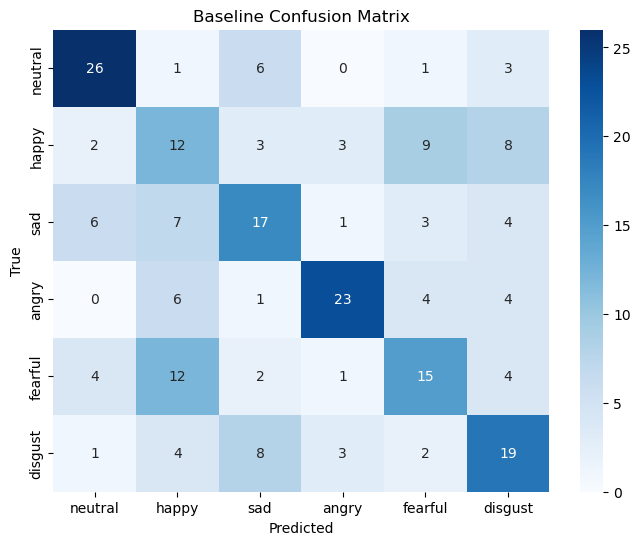

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# evaluate on hold-out test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f"Baseline Test Accuracy: {test_acc:.4f}")
print(f"Baseline Test Loss: {test_loss:.4f}")

# predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# classification report
print(classification_report(y_true, y_pred_classes, target_names=selected_emotions))

# confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=selected_emotions, yticklabels=selected_emotions)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Baseline Confusion Matrix")
plt.show()

---

## 6. Creating a refined CNN Model <a id="creating-a-refined-cnn-model"></a>
### Introducing hyperparameter tuning <a id="introducing-hyperparameter-tuning"></a>
We perform hyperparameter tuning as part of the refined CNN model - allowing us to do a random search to optimize its hyperparameters. The specific parameters tuned include:

- the number of convolutional filters in each layer (`filters1`, `filters2`, `filters3`)  
- the number of units in the dense (fully connected) layer (`dense_units`)  
- the dropout rate for regularization (`dropout`)  
- the learning rate for the Adam optimizer (`lr`)

Once iterated through 10 trials, the best hyperparameters found are displayed, to be used in the next stage.

In [9]:
import keras_tuner as kt

def model_builder(hp):
    return build_cnn_model(
        filters=[
            hp.Choice('filters1', [16, 32]),
            hp.Choice('filters2', [32, 64]),
            hp.Choice('filters3', [64, 128])
        ],
        dense_units=hp.Int('dense_units', 64, 192, step=64),
        dropout_rate=hp.Float('dropout', 0.2, 0.5, step=0.1),
        learning_rate=hp.Choice('lr', [1e-4, 5e-4, 1e-3])
    )

tuner = kt.RandomSearch(
    model_builder,
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial=1,
    overwrite=True,
    directory="tuner_logs",
    project_name="emotion_cnn"
)

# launch hyperparameter search
tuner.search(
    X_train, y_train,
    validation_split=0.2,  # 20% used for validation during tuning
    epochs=20,
    batch_size=32
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters found:", best_hps.values)

Trial 10 Complete [00h 00m 17s]
val_accuracy: 0.4888888895511627

Best val_accuracy So Far: 0.5666666626930237
Total elapsed time: 00h 04m 00s
Best hyperparameters found: {'filters1': 32, 'filters2': 32, 'filters3': 128, 'dense_units': 64, 'dropout': 0.2, 'lr': 0.001}


### Implementing k-fold cross validation <a id="implementing-k-fold-cross-validation"></a>
We perform stratified k-fold cross-validation to evaluate the CNN model. The dataset is divided into **5 folds**, keeping class proportions balanced. For each fold, the model is trained on 4 folds and validated on the remaining fold. Validation accuracies are recorded for all folds to assess overall performance.

In [10]:
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import load_model

def run_kfold_cv(X, y, k=5, hyperparams=None, epochs=20, batch_size=32, save_best_model=False, save_path="best_model.keras"):
    """
    Runs k-fold cross-validation with the given hyperparameters.
    Returns a list of fold accuracies.
    Optionally saves the model from the best-performing fold.
    """
    if hyperparams is None:
        hyperparams = {}

    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    cv_accuracies = []
    best_acc = -1
    best_model = None

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        print(f"\n===== Fold {fold} =====")
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        X_train = X_train[..., np.newaxis]
        X_val   = X_val[..., np.newaxis]
        y_train = to_categorical(y_train, num_classes=num_classes)
        y_val   = to_categorical(y_val, num_classes=num_classes)

        model = build_cnn_model(**hyperparams)
        model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            verbose=0
        )

        val_acc = model.evaluate(X_val, y_val, verbose=0)[1]
        print(f"Fold {fold} val_acc: {val_acc:.4f}")
        cv_accuracies.append(val_acc)

        # save the best fold model
        if save_best_model and val_acc > best_acc:
            best_acc = val_acc
            best_model = model

    print("\n=== Cross-validation results ===")
    print("Mean accuracy:", np.mean(cv_accuracies))
    print("Std deviation:", np.std(cv_accuracies))

    if save_best_model and best_model is not None:
        best_model.save(save_path)
        print(f"Best model saved to {save_path} with accuracy {best_acc:.4f}")

    return cv_accuracies

### Building and training the refined model <a id="building-and-training-the-refined-model"></a>
The best hyperparameters found earlier are used to train the refined model using 5-fold cross validation - a combination of both techniques covered so far. The best-performing model, `emotion_cnn_best.keras`, is saved for later use.

In [11]:
best_hyperparams = {
    "filters": [
        best_hps.get('filters1'),
        best_hps.get('filters2'),
        best_hps.get('filters3')
    ],
    "dense_units": best_hps.get('dense_units'),
    "dropout_rate": best_hps.get('dropout'),
    "learning_rate": best_hps.get('lr')
}

print("\nRunning tuned k-fold cross validation...")
tuned_cv_accs = run_kfold_cv(
    X, y, k=5,
    hyperparams=best_hyperparams,
    epochs=20,
    batch_size=32,
    save_best_model=True,
    save_path="emotion_cnn_best.keras"
)

print("Tuned CV Mean Accuracy:", np.mean(tuned_cv_accs))
print("Best Fold Accuracy:", np.max(tuned_cv_accs))


Running tuned k-fold cross validation...

===== Fold 1 =====
Fold 1 val_acc: 0.5689

===== Fold 2 =====
Fold 2 val_acc: 0.5289

===== Fold 3 =====
Fold 3 val_acc: 0.6027

===== Fold 4 =====
Fold 4 val_acc: 0.4777

===== Fold 5 =====
Fold 5 val_acc: 0.5357

=== Cross-validation results ===
Mean accuracy: 0.5427698433399201
Std deviation: 0.041834436768429566
Best model saved to emotion_cnn_best.keras with accuracy 0.6027
Tuned CV Mean Accuracy: 0.5427698433399201
Best Fold Accuracy: 0.6026785969734192


### Evaluating the refined model <a id="evaluating-the-refined-model"></a>
Similar to the evaluation of the baseline model, we assess the performance of the refined model on the test set by:
- computing **test loss and accuracy** to measure overall performance,
- generating **predicted classes** and compare with true labels,
- printing a **classification report** showing precision, recall, and F1-score for each emotion, and
- creating a **confusion matrix** heatmap to visualize prediction errors across classes.

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8771 - loss: 0.5292
Final Test Accuracy: 0.8933
Final Test Loss: 0.5034
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Classification Report:
              precision    recall  f1-score   support

     neutral       0.97      0.95      0.96        37
       happy       0.82      0.89      0.86        37
         sad       0.92      0.87      0.89        38
       angry       0.84      1.00      0.92        38
     fearful       0.91      0.84      0.88        38
     disgust       0.91      0.81      0.86        37

    accuracy                           0.89       225
   macro avg       0.90      0.89      0.89       225
weighted avg       0.90      0.89      0.89       225



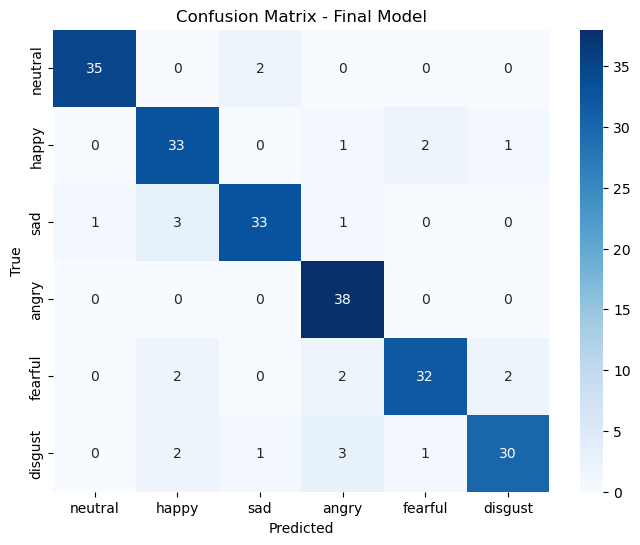

In [12]:
from tensorflow.keras.models import load_model

# load the best fold model
final_model = load_model("emotion_cnn_best.keras")

# evaluate on hold-out test set
test_loss, test_acc = final_model.evaluate(X_test, y_test, verbose=1)
print(f"Final Test Accuracy: {test_acc:.4f}")
print(f"Final Test Loss: {test_loss:.4f}")

# predictions
y_pred = final_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=selected_emotions))

# confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=selected_emotions, yticklabels=selected_emotions)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Final Model")
plt.show()

---

## 7. Summary and next steps <a id="summary"></a>

### Summary
We have successfully built a convolutional neural network (CNN) model capable of classifying emotional speech into six categories:
- neutral
- happy
- sad
- angry
- fearful
- disgust

Using mel-spectrograms derived from the CREMA-D and RAVDESS datasets, the model demonstrates promising performance, making it a reliable tool for evaluating emotion-related transformations in audio. The trained model has been saved (as *emotion_cnn_best.keras*) and is ready for use in downstream tasks.

### Next steps
In the following stage of the project, we will implement a neural style transfer mechanism that applies the prosodic and emotional "style" of one audio sample onto the content of another. The emotion classifier developed in this notebook will be used to assess whether the stylised outputs successfully convey the intended target emotion.